In [23]:
import os
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

        #Spectral centroid
    sc = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, sc))

    #Spectral Spread
    ss = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, ss))

    # Spectral Flux
    sf = np.mean(librosa.onset.onset_strength(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, sf))

    # Spectral Roll-Off
    srf = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, srf))

    # Chroma Vector
    cv = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, cv))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

In [5]:
def get_features():
    data, sample_rate = librosa.load(os.path.join(data_folder, filename), duration=2.5, offset=0.6)
    
    res = extract_features(data, sample_rate)
    result = np.array(res)
    
    return result

In [6]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw_file')
X, Y = [], []
for filename in os.listdir(data_folder):
    feature = get_features()
    file_parts = filename.split('-')
    emotion = int(file_parts[2])
    X.append(feature)
    Y.append(emotion)

In [7]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv(r"../data/data_proccesed.csv",index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,0.000004,0.000003,0.000002,0.000002,0.000005,0.000008,0.000007,0.000005,4.245834e-07,1
1,0.256113,0.621621,0.580278,0.598515,0.628296,0.598015,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,1
2,0.207361,0.665823,0.670921,0.684690,0.707034,0.734071,0.654613,0.594455,0.626005,0.704741,...,0.000064,0.000052,0.000039,0.000034,0.000032,0.000050,0.000098,0.000061,6.169706e-06,1
3,0.268903,0.601669,0.529868,0.497117,0.550246,0.579884,0.636898,0.690209,0.654453,0.590455,...,0.000047,0.000046,0.000026,0.000032,0.000020,0.000023,0.000017,0.000007,8.532165e-07,1
4,0.163827,0.690411,0.748767,0.742984,0.678114,0.662585,0.633123,0.590499,0.698888,0.720797,...,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,1.043211e-07,1


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [32]:
from tensorflow.keras import layers
from tensorflow.keras import models


def custom_scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
scheduler = LearningRateScheduler(custom_scheduler)

normalizer = layers.Normalization()
normalizer.adapt(X)

model = models.Sequential([
    layers.Input(shape=(x_train.shape[1], 1)),
    normalizer,
    # layers.Reshape((89, 2)),
    layers.Conv1D(512, 1, activation='relu'),
    layers.Conv1D(256, 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(128, 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(64, 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(32, 1, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [33]:
history=model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test),callbacks=scheduler)

Epoch 1/40
36/36 [==============================] - 3s 51ms/step - loss: 31124.6875 - accuracy: 0.1085 - val_loss: 453.4112 - val_accuracy: 0.0868 - lr: 0.0010
Epoch 2/40
36/36 [==============================] - 2s 45ms/step - loss: 527.5616 - accuracy: 0.1415 - val_loss: 6.3223 - val_accuracy: 0.2431 - lr: 0.0010
Epoch 3/40
36/36 [==============================] - 2s 46ms/step - loss: 3.4776 - accuracy: 0.1745 - val_loss: 2.1473 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 4/40
36/36 [==============================] - 2s 49ms/step - loss: 2.1273 - accuracy: 0.2205 - val_loss: 1.9184 - val_accuracy: 0.3090 - lr: 0.0010
Epoch 5/40
36/36 [==============================] - 2s 51ms/step - loss: 2.0167 - accuracy: 0.2240 - val_loss: 1.8575 - val_accuracy: 0.3160 - lr: 9.0484e-04
Epoch 6/40
36/36 [==============================] - 2s 50ms/step - loss: 1.9702 - accuracy: 0.2587 - val_loss: 1.8484 - val_accuracy: 0.2917 - lr: 8.1873e-04
Epoch 7/40
36/36 [==============================] - 2s 48ms/

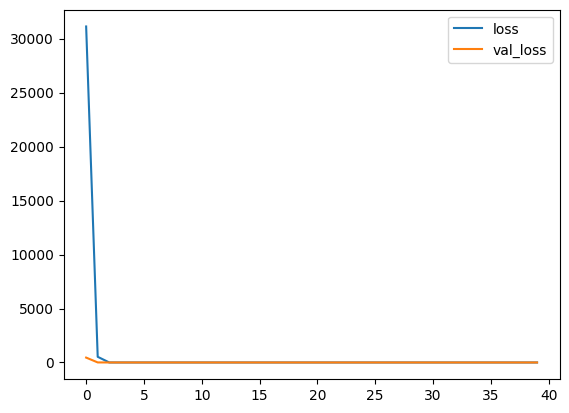

In [34]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

9/9 [==============================] - 0s 22ms/step
Test set accuracy: 34%


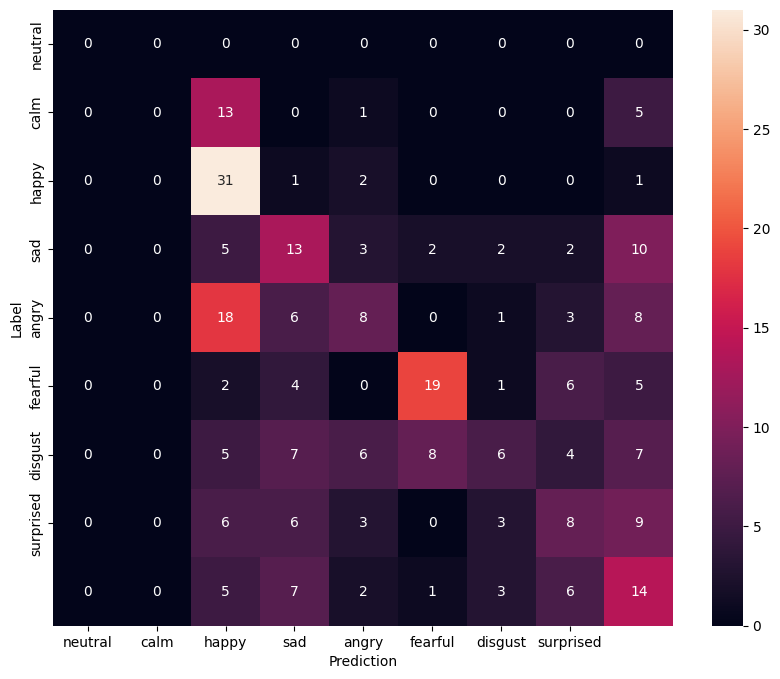

In [38]:
commands=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [39]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 0s 16ms/step - loss: 1.7292 - accuracy: 0.3438


[1.729158878326416, 0.34375]